# Check model's perfomance on batches with different size

### Required classes:

* Tokenizer
* Pipeline's members (several classes)
* Perfomance Checker
* Models Loader


## Import libraries

In [1]:
import pythonnet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import sys
import subprocess
import json

from typing import List, Union, Dict, Iterable, Tuple

## Import DLL libraries for tokenizer's work

In [2]:
import os
os.environ["DOTNET_ROOT"] = r"C:\Program Files\dotnet"

In [3]:
from clr_loader import get_coreclr
from pythonnet import set_runtime

config_file_path: str = r"C:\Users\Maksim\Obfuscation\Tokenizer\pspython.runtimeconfig.json"
runtime = get_coreclr(runtime_config=config_file_path)
set_runtime(runtime)

pythonnet.get_runtime_info()

RuntimeInfo(kind='CoreCLR', version='<undefined>', initialized=True, shutdown=False)

In [4]:
import clr 
import System 

psl_home_folder = r"C:\Program Files\PowerShell\7\\"
mmi_filepath = psl_home_folder + r'Microsoft.Management.Infrastructure.dll'
clr.AddReference(mmi_filepath)

sma_filepath = psl_home_folder + r"System.Management.Automation.dll"
clr.AddReference(sma_filepath);

In [5]:
sys.path.append(r"C:\Users\Maksim\source\repos\PSFeatureExtractorLibrary\PSFeatureExtractorLibrary\bin\Debug\net6.0")
clr.AddReference("PSFeatureExtractorLibrary")

import PSFeatureExtractorLibrary

## Tokenizer

In [6]:
class Tokenizer:
    __ANALYZING_METHODS = [
        PSFeatureExtractorLibrary.GroupedArrayElementRangeCounts.AnalyzeAst,
        PSFeatureExtractorLibrary.ArrayElementMetrics.AnalyzeAst,
        PSFeatureExtractorLibrary.GroupedAssignmentStatements.AnalyzeAst,
        PSFeatureExtractorLibrary.GroupedAstTypes.AnalyzeAst,
        PSFeatureExtractorLibrary.GroupedBinaryExpressionOperators.AnalyzeAst,
        PSFeatureExtractorLibrary.CmdletMetrics.AnalyzeAst,
        PSFeatureExtractorLibrary.CommandParameterNameMetrics.AnalyzeAst,
        PSFeatureExtractorLibrary.CommentMetrics.AnalyzeAst,
        PSFeatureExtractorLibrary.ConvertExpressionMetrics.AnalyzeAst,
        PSFeatureExtractorLibrary.FunctionNameMetrics.AnalyzeAst,
        PSFeatureExtractorLibrary.IntegerAndDoubleMetrics.AnalyzeAst,
        PSFeatureExtractorLibrary.InvocationOperatorInvokedObjectMetrics.AnalyzeAst,
        PSFeatureExtractorLibrary.LineByLineMetrics.AnalyzeAst,
        PSFeatureExtractorLibrary.MemberArgumentMetrics.AnalyzeAst,
        PSFeatureExtractorLibrary.MemberMetrics.AnalyzeAst,
        PSFeatureExtractorLibrary.StringMetrics.AnalyzeAst,
        PSFeatureExtractorLibrary.TypeConstraintMetrics.AnalyzeAst,
        PSFeatureExtractorLibrary.TypeExpressionMetrics.AnalyzeAst,
        PSFeatureExtractorLibrary.GroupedUnaryExpressionOperators.AnalyzeAst,
        PSFeatureExtractorLibrary.VariableNameMetrics.AnalyzeAst,
    ]
    
    __LENGTHS: List[int] = [22, 312, 14, 152, 104, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 26, 312]
        
    def __init__(self) -> None:
        self.__CUMULATIVE_LENGTHS: np.ndarray[int] = np.cumsum(self.__LENGTHS)
            
    @staticmethod
    def create_dataframe(columns: Iterable[str], values: List[Union[int, float]]) -> pd.DataFrame:
        result: pd.DataFrame = pd.DataFrame(data=values, columns=columns)
        return result
    
    def tokenize_CS(self, command: str) -> pd.DataFrame:
        ast, token, parse_error = System.Management.Automation.Language.Parser.ParseInput(command)
        
        if len(parse_error) > 0:
            raise ValueError(f"Parse errors were occured while parsing command {command}")
        
        total_features: int = self.__CUMULATIVE_LENGTHS[-1]
        result_values: List[Union[int, float]] = [0.0] * total_features
        features: List[str] = ["" for _ in range(total_features)]
            
        start_index: int = 0
        end_index: int = self.__CUMULATIVE_LENGTHS[0]
        
        for i in range(len(self.__ANALYZING_METHODS)):
            end_index = self.__CUMULATIVE_LENGTHS[i]
            command_handling_result_dict = self.__ANALYZING_METHODS[i](ast)
            result_values[start_index:end_index] = list(command_handling_result_dict.Values)
            features[start_index:end_index] = list(command_handling_result_dict.Keys)
            start_index = end_index
                    
        result: pd.DataFrame = self.create_dataframe(columns=features, values=[result_values])
        return result

## Model loader

In [7]:
import sklearn

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

Model = Union[
    MultinomialNB,
    GaussianNB,
    SVC,
    LogisticRegression,
    KNeighborsClassifier,
    DecisionTreeClassifier,
]

In [8]:
class Loader:
    def __init__(self, pkl_filenames: Dict[str, str]) -> None:
        self.__pkl_filenames: Dict[str, str] = pkl_filenames  # model_name: filename
    
    def load_models(self) -> Dict[str, Model]:
        models: Dict[str, Model] = {}  # model_name: model
        mode: str = "rb"
        for model_name, pkl_filename in self.__pkl_filenames.items():
            try:
                with open(pkl_filename, mode) as file:
                    pickle_model: Model = pickle.load(file)
                models[model_name] = pickle_model
            except Exception as e:
                print(f"The exception was occured while loading {model_name} model from file {pkl_filename}: {e}.")
        return models

## Pipeline parts

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [10]:
class UselessFeaturesDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop_features_txt_filename: str) -> None:
        super().__init__()
        self.__drop_features: List[str] = self.get_features_to_drop(drop_features_txt_filename)
    
    @staticmethod
    def get_features_to_drop(drop_features_txt_filename: str) -> List[str]:
        drop_features: List[str] = []
        with open(drop_features_txt_filename, 'r') as file:
            drop_features = [drop_feature.strip(' \n') for drop_feature in file.readlines()]
        return drop_features
    
    def fit(self, X: pd.DataFrame, y: pd.Series = None) -> "UselessFeaturesDropper":
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return X.drop(self.__drop_features, axis=1)

## Perfomance Checker

In [11]:
class PerfomanceChecker:
    def __init__(self, commands: Iterable[str], models: Dict[str, Model], features_dropper: UselessFeaturesDropper) -> None:
        self.__commands: pd.Series[str] = pd.Series(commands)
        self.__models: Dict[str, Model] = models
        self.__features_dropper: UselessFeaturesDropper = features_dropper
        self.__tokenizer: Tokenizer = Tokenizer()
            
    def analyze(self, batch_size: int, filename: str = None) -> Tuple[Dict[str, Dict[str, int]], Dict[str, List[float]]]:
        predictions: Dict[str, Dict[str, int]] = {model_name: {} for model_name in self.__models.keys()}  # model_name: {command: prediction}
        batch_times: Dict[str, List[float]] = {model_name: [] for model_name in self.__models.keys()}  # model_name: times on batches
        order: np.ndarray[int] = np.random.permutation(len(self.__commands))
        missed_commands: Set[str] = set()
        
        print(f"Analyzing command with batch size {batch_size} is running...\n")
        for start_index in range(0, len(self.__commands), batch_size):
            counter_missed_commands_in_all_previous_batches: int = len(missed_commands)
            batch_indexes: np.ndarray[int] = order[start_index:start_index + batch_size]
            commands_batch: List[str] = self.__commands[batch_indexes]
                
            for model_name, model in self.__models.items():
                start_time: float = time.time()
                    
                for command in commands_batch:
                    prediction: int = self.predict_command_obfuscation(command=command, model_name=model_name)
                    if prediction is None:
                        missed_commands.add(command)
                        continue
                    predictions[model_name][command] = prediction
                
                end_time: float = time.time()
                batch_times[model_name].append(end_time - start_time)
                
            print(f"{min(start_index + batch_size, len(order))} commands are processed.")
            print(f"But... There're {len(missed_commands) - counter_missed_commands_in_all_previous_batches} missed commands in this batch (out of {len(commands_batch)} commands).\n")
            
        if filename is not None:
            self.write(data=missed_commands, filename=filename)
        print(f"Analyzing commands with batch size {batch_size} has ended.\n")
        return predictions, batch_times
    
    @staticmethod
    def write(data: List[str], filename: str) -> None:
        with open(filename, mode='a') as file:
            data_separated_by_line: List[str] = [f"{item}\n" for item in data]
            file.writelines(data_separated_by_line)
            
    def predict_command_obfuscation(self, command: str, model_name: str) -> int:
        try:
            df_tokenized: pd.DataFrame = self.__tokenizer.tokenize_CS(command)
        except Exception as e:
            return None
        
        df_with_main_features: pd.DataFrame = self.__features_dropper.fit_transform(df_tokenized)
        df_preprocessed: pd.DataFrame = pd.DataFrame(MinMaxScaler().fit_transform(df_with_main_features), columns=df_with_main_features.columns)
        model: Model = self.__models.get(model_name, None)

        if model is not None:
            return model.predict(df_preprocessed)
        raise ValueError("Некорректное имя модели")

## Import Malicious PowerShell commands from Excel file to analyze

In [12]:
file_path: str = r"D:\Obfuscation\data\datasets\additional\data\Malicious_POWERSHELL.xlsx"
    
malicious_powershell_df = pd.read_excel(io=file_path)
commands: pd.Series = malicious_powershell_df["command"]

## Analyzing

In [13]:
def plot_predicitions(predictions: Dict[str, Dict[str, int]]) -> None:
    model_predictions: Dict[str, List[int]] = {model_name: [0, 0] for model_name in predictions.keys()}
    for model_name, predictions_for_command in predictions.items():
        for command, prediction_value in predictions_for_command.items():
            model_predictions[model_name][prediction_value[0]] += 1
    
    ncols: int = 2
    fig, axes = plt.subplots(ncols=ncols, 
                             nrows=len(model_predictions) // ncols if not len(model_predictions) % ncols else len(model_predictions) // ncols + 1, 
                             figsize=(10, 14))
    
    for i in range(len(model_predictions)):
        model_name: str = list(model_predictions.keys())[i]
        x = np.arange(len(model_predictions[model_name]))
        y = model_predictions[model_name]
        
        col: int = i % ncols
        row: int = i // ncols
        ax = axes[row, col]              
        
        ax.set_title(f"{model_name} model")
        ax.set_xticks(x)
        ax.bar(x, y)

In [14]:
def plot_times(times: List[float], batch_size: int, total_size: int, model_name: str) -> None:
    x_values: List[int] = [batch_size * i if batch_size * i < total_size else total_size for i in range(1, len(times) + 1)]
    
    figure = plt.figure(figsize=(10, 7))
    plt.plot(x_values, times)
    plt.title(f"Measured times with batch size = {batch_size} for {model_name}")
    plt.grid()
    plt.xlabel("Commands quantity")
    plt.ylabel("Measured time in seconds")

In [15]:
models_filenames: Dict[str, str] = {
    "GaussianNB": r"D:\Obfuscation\models\GaussianNB_model.pkl",
    "MultinomialNB": r"D:\Obfuscation\models\MultinomialNB_model.pkl",
    "LogisticRegression": r"D:\Obfuscation\models\LogisticRegression_model.pkl",
    "KNearestNeighbors": r"D:\Obfuscation\models\KNearestNeighbors_model.pkl",
    "SupportVectorMachines": r"D:\Obfuscation\models\SupportVectorMachines_model.pkl",
    "RandomForestClassifier": r"D:\Obfuscation\models\RandomForestClassifier_model.pkl",
    "DecisionTreeClassifier": r"D:\Obfuscation\models\DecisionTreeClassifier_model.pkl",
}
    
loader: Loader = Loader(models_filenames)
models: Dict[str, Model] = loader.load_models()

In [16]:
for model_name, model in models.items():
    print(f"{model_name}: {model}\n")

GaussianNB: GaussianNB(var_smoothing=1e-06)

MultinomialNB: MultinomialNB(alpha=1e-05)

LogisticRegression: LogisticRegression(C=0.1, max_iter=1000, multi_class='ovr', n_jobs=-1,
                   penalty='l1', solver='liblinear')

KNearestNeighbors: KNeighborsClassifier(n_jobs=-1)

SupportVectorMachines: SVC(C=0.1, kernel='linear')

RandomForestClassifier: RandomForestClassifier(max_depth=80, min_samples_leaf=2, min_samples_split=10,
                       n_jobs=-1)

DecisionTreeClassifier: DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=4)



In [17]:
drop_features_filename: str = "D:\Obfuscation\data\drop_features.txt"
    
features_dropper: UselessFeaturesDropper = UselessFeaturesDropper(drop_features_filename)

In [18]:
perfomance_checker: PerfomanceChecker = PerfomanceChecker(
    commands=commands,
    models=models,
    features_dropper=features_dropper
)

Analyzing command with batch size 500 is running...

500 commands are processed.
But... There're 29 missed commands in this batch (out of 500 commands).

1000 commands are processed.
But... There're 35 missed commands in this batch (out of 500 commands).

1500 commands are processed.
But... There're 25 missed commands in this batch (out of 500 commands).

2000 commands are processed.
But... There're 19 missed commands in this batch (out of 500 commands).

2500 commands are processed.
But... There're 23 missed commands in this batch (out of 500 commands).

2935 commands are processed.
But... There're 18 missed commands in this batch (out of 435 commands).

Analyzing commands with batch size 500 has ended.

For model GaussianNB batch times are equal to [64.52738380432129, 64.31075978279114, 73.39871144294739, 65.8007493019104, 65.08846259117126, 62.34701752662659]

For model MultinomialNB batch times are equal to [64.22250699996948, 63.38752508163452, 64.51888370513916, 65.40966939926147

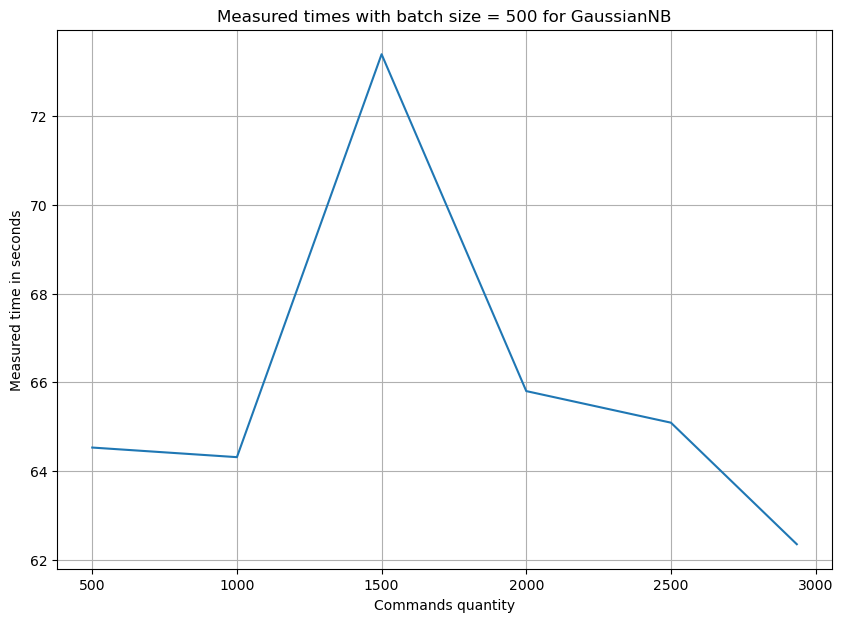

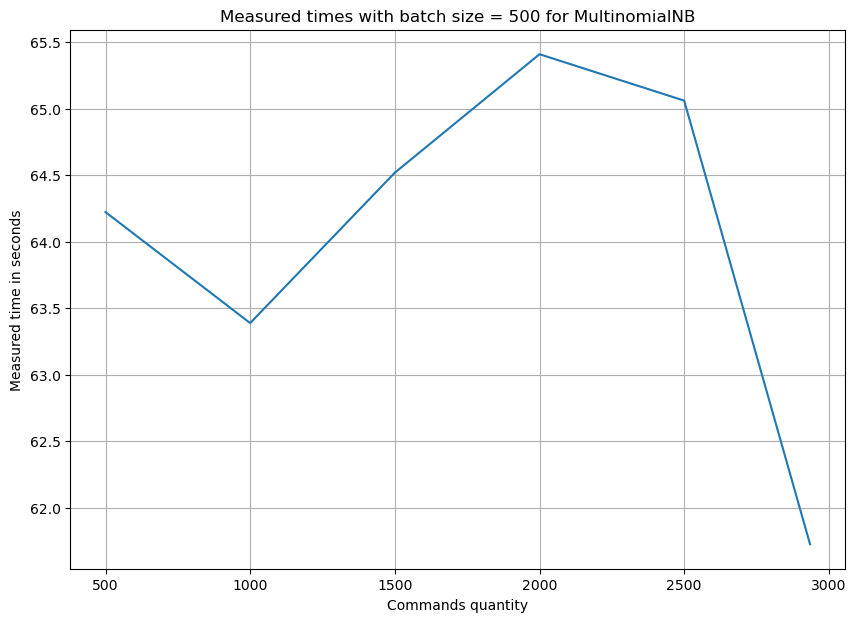

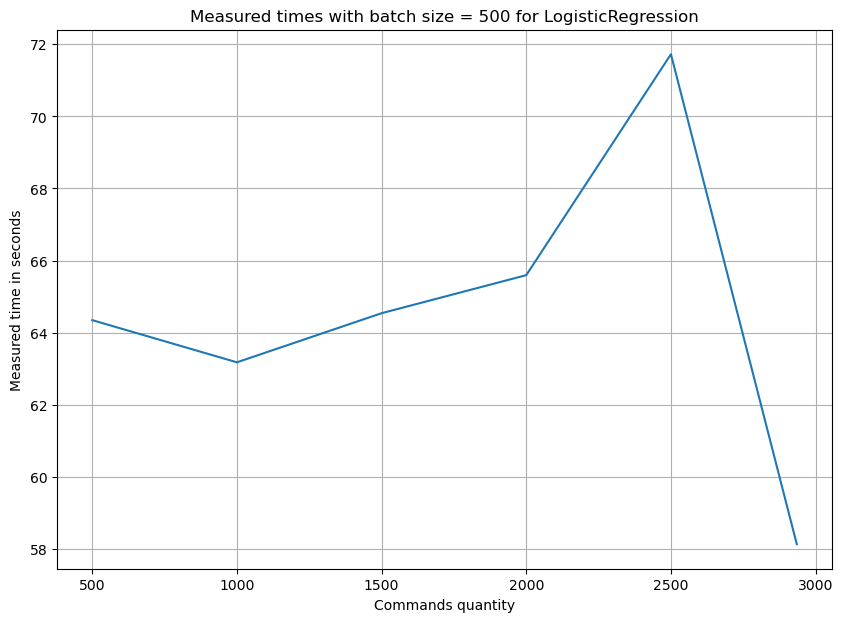

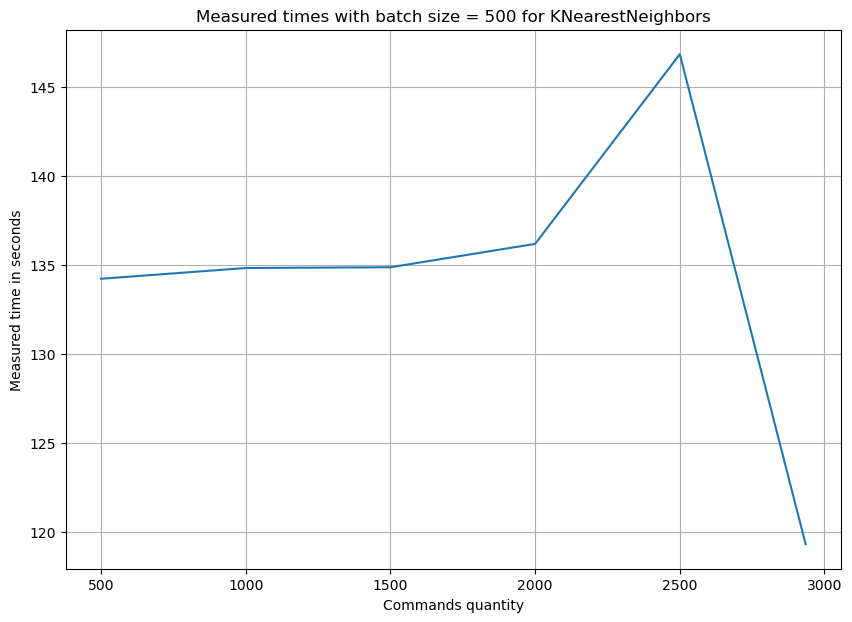

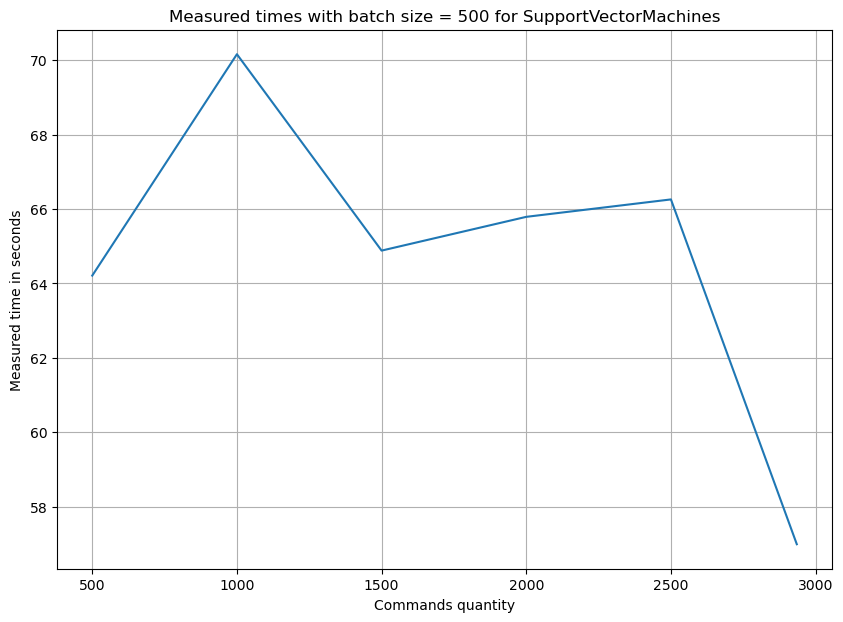

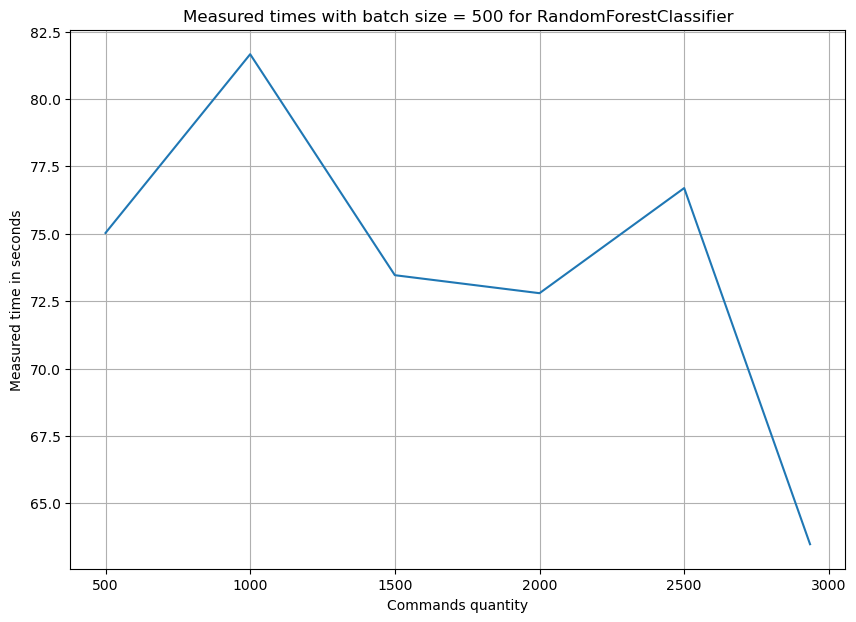

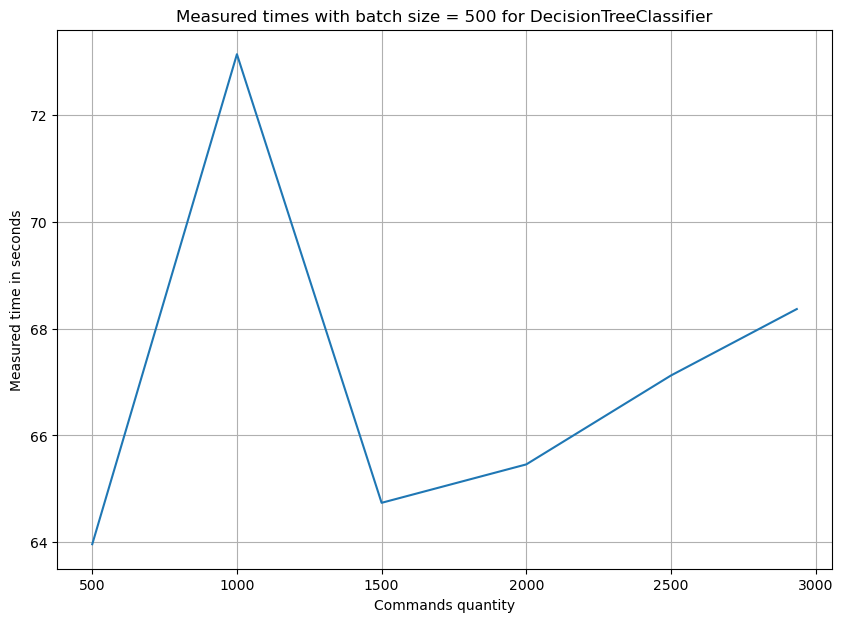

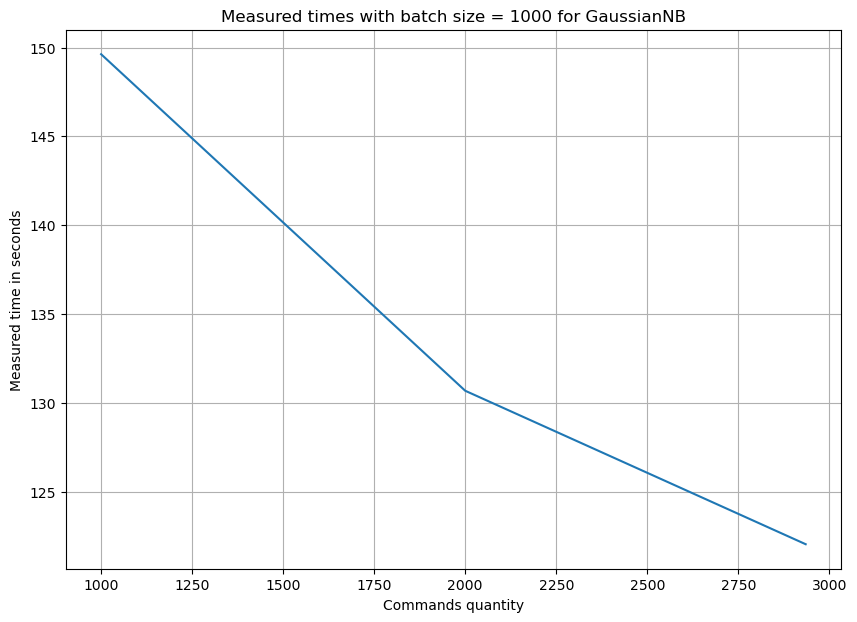

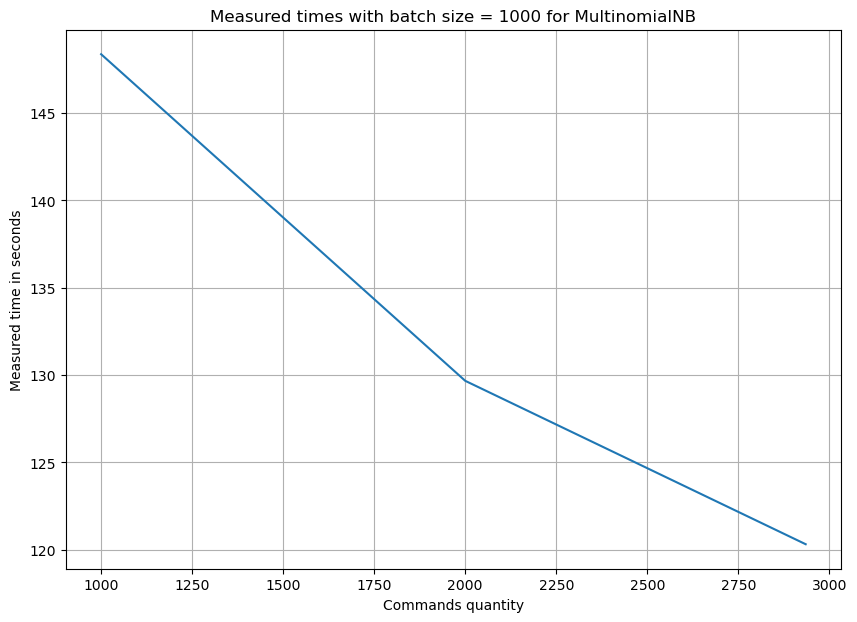

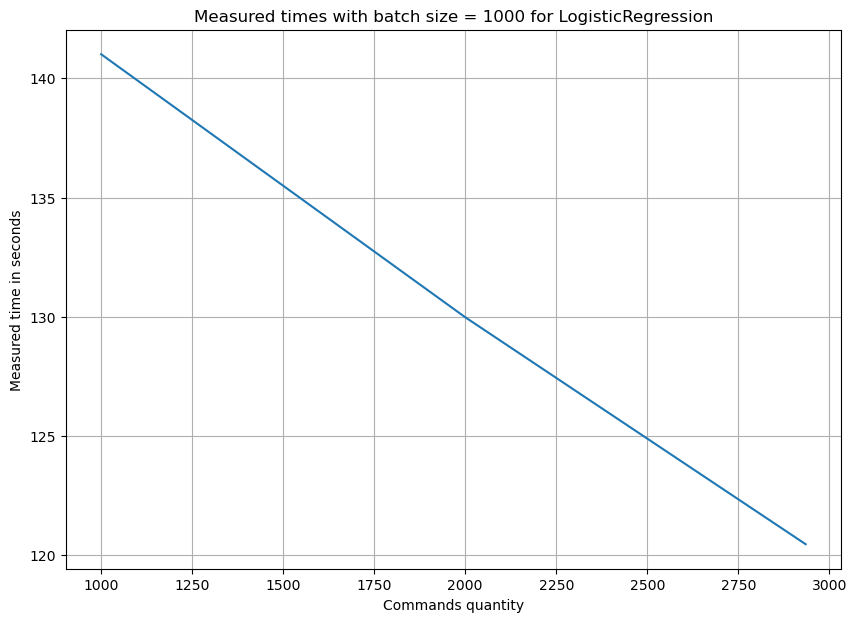

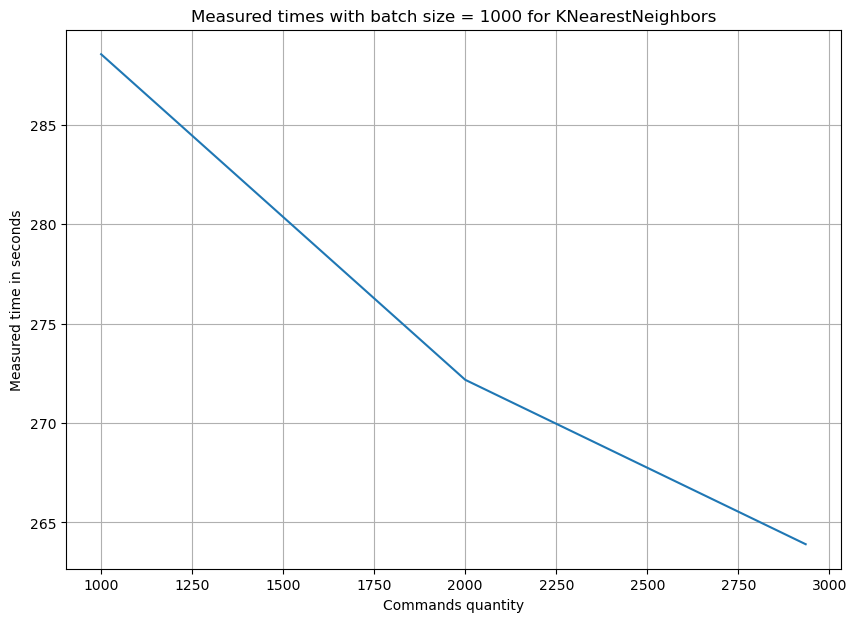

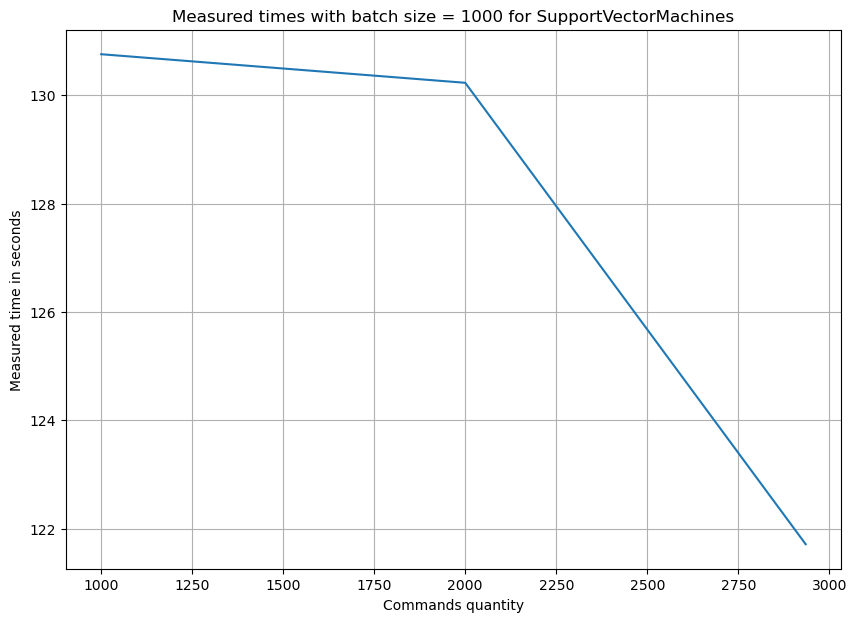

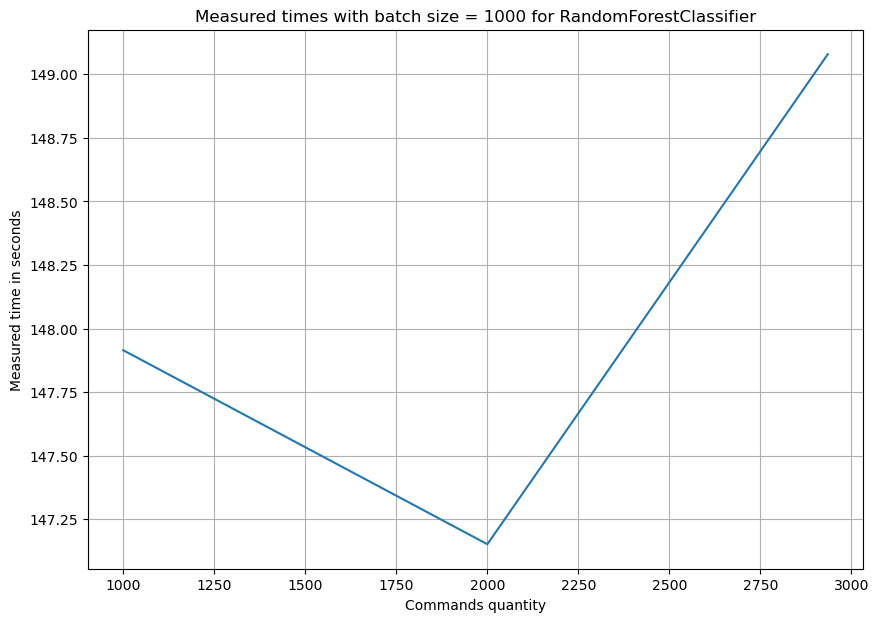

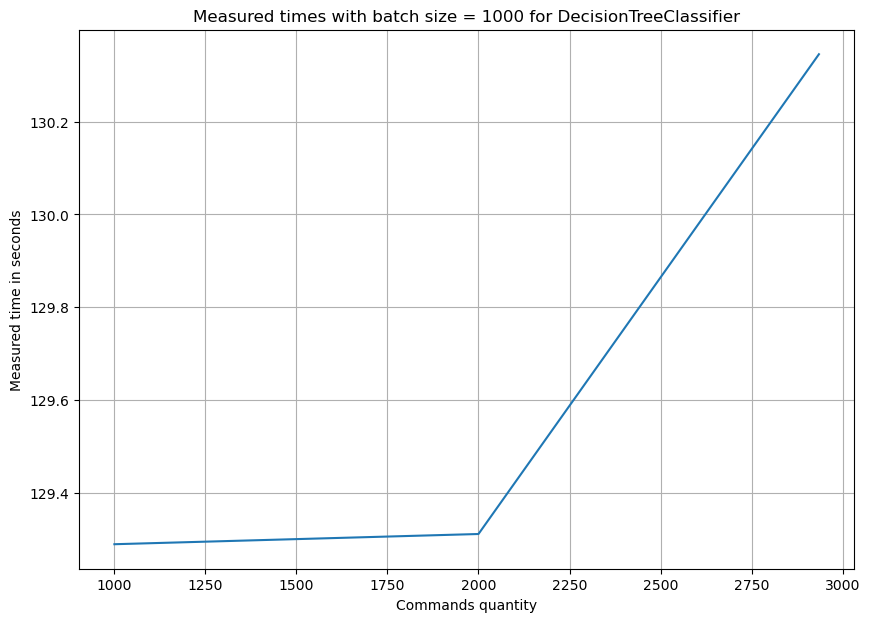

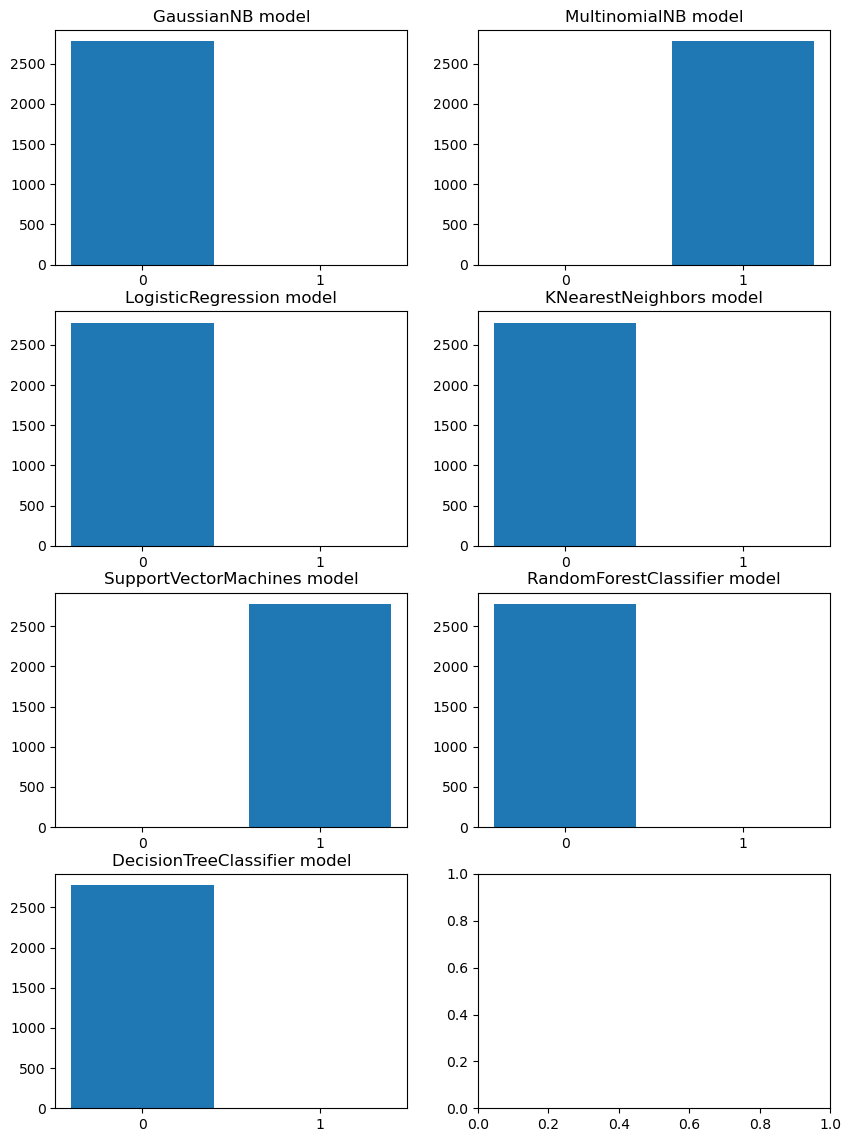

In [19]:
batch_sizes: Tuple[int, ...] = (500, 1000, )
missed_commands_filenames: Tuple[str, ...] = (
    r"D:\Obfuscation\data\missed_commands_while_batch_analyzing\missed_commands_500.txt",
    r"D:\Obfuscation\data\missed_commands_while_batch_analyzing\missed_commands_1000.txt",
)
    
predictions: Dict[str, Dict[str, int]] = {}  # model_name: {command: prediction}
batch_times: Dict[str, List[float]] = {}  # model_name: batch_times

for batch_size, filename in zip(batch_sizes, missed_commands_filenames):
    predictions, batch_times = perfomance_checker.analyze(batch_size, filename=filename)
    for model_name, times in batch_times.items():
        plot_times(times=times, batch_size=batch_size, total_size=len(commands), model_name=model_name)
        print(f"For model {model_name} batch times are equal to {times}\n")
    print("\n\n\n\n\n")
plot_predicitions(predictions)